## Part VI: Natural Language Supervision

We will compare the performance of:

(a) traditional supervision - positive and negative labels on examples

(b) natural language supervision - explanations converted into LFs, which are then denoised and applied to unlabeled data to create a much larger but noisy training set

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
# os.environ['SNORKELDB'] = 'postgres:///snorkel-intro'

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

We repeat our definition of the `Spouse` `Candidate` subclass from Parts II and III.

In [2]:
from snorkel.models import candidate_subclass
Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

In [3]:
from snorkel.annotations import FeatureAnnotator
featurizer = FeatureAnnotator()

In [4]:
F_train = featurizer.load_matrix(session, split=0)
F_dev   = featurizer.load_matrix(session, split=1)
F_unlabeled   = featurizer.load_matrix(session, split=3)

In [5]:
from snorkel.annotations import load_gold_labels
L_gold_train = load_gold_labels(session, annotator_name='gold', split=0)
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

## (b) Natural Language Supervision

In [25]:
# PYTHON LFs
from pprint import pprint
from python_lfs import get_python_lfs

python_lfs = get_python_lfs()
pprint(python_lfs)
# LFs = python_lfs

[<function LF_distant_supervision at 0x119e7a0c8>,
 <function LF_distant_supervision_last_names at 0x119e7a140>,
 <function LF_husband_wife at 0x119e77b90>,
 <function LF_husband_wife_left_window at 0x119e77c08>,
 <function LF_same_last_name at 0x119e77c80>,
 <function LF_no_spouse_in_sentence at 0x119e77cf8>,
 <function LF_and_married at 0x119e77d70>,
 <function LF_familial_relationship at 0x119e77de8>,
 <function LF_family_left_window at 0x119e77e60>,
 <function LF_other_relationship at 0x119e77ed8>]


In [ ]:
# NL LFs
spouse = ['wife', 'husband', 'ex-wife', 'ex-husband']
family = ['father', 'mother', 'sister', 'brother', 'son', 'daughter',
          'grandfather', 'grandmother', 'uncle', 'aunt', 'cousin']
family = family + [f + '-in-law' for f in family]
coworker = ['boss', 'employee', 'secretary', 'co-worker']

user_lists = {'spouse': spouse,
              'family': family,
              'coworker': coworker}

explanations = [
    "Label false because the number of words between arg 1 and arg 2 is larger than 10",
    "Label false because there is a person between arg 1 and arg 2",
    "Label true because there is at least one spouse word in the words between arg 1 and arg 2",
    "Label true because there is at least one spouse word within two words to the left of arg 1 or arg 2",
    "Label false because there are no spouse words in the sentence",
    "Label true because the word 'and' is between arg 1 and arg 2 and 'married' is to the right of arg 2",
    "Label false because there is at least one family word between arg 1 and arg 2",
    "Label false because there is at least one family word within two words to the left of arg 1 or arg 2",
    "Label false because there is at least one coworker word between arg 1 and arg 2",
#     "Label false because arg 1 is identical to arg 2",
]

In [ ]:
import sys
sys.path.insert(0, '/Users/bradenhancock/sippycup')

In [ ]:
from sippy_snorkel_interface import SemanticParser

sp = SemanticParser()
LFs = sp.parse(explanations, user_lists=user_lists, verbose=True)

In [ ]:
for lf in LFs:
    print lf

In [ ]:
LFs = LFs[:3] + LFs[4:]

### Investigate one LF

In [ ]:
lf = LFs[4]
print lf

In [ ]:
labeled = []
for c in session.query(Spouse).filter(Spouse.split == 3).all():
    try:
        if lf(c) != 0:
            labeled.append(c)
    except:
        pass
print "Number labeled:", len(labeled)

In [ ]:
from snorkel.viewer import SentenceNgramViewer

sv = SentenceNgramViewer(labeled[:300], session)
sv

In [ ]:
from snorkel.lf_helpers import test_LF
tp, fp, tn, fn = test_LF(session, lf, split=0, annotator_name='gold')

### Apply all LFs

[<function LF_distant_supervision at 0x119e7a0c8>,
 <function LF_distant_supervision_last_names at 0x119e7a140>,
 <function LF_husband_wife at 0x119e77b90>,
 <function LF_husband_wife_left_window at 0x119e77c08>,
 <function LF_same_last_name at 0x119e77c80>,
 <function LF_no_spouse_in_sentence at 0x119e77cf8>,
 <function LF_and_married at 0x119e77d70>,
 <function LF_familial_relationship at 0x119e77de8>,
 <function LF_family_left_window at 0x119e77e60>,
 <function LF_other_relationship at 0x119e77ed8>]


In [7]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(f=LFs)

In [ ]:
np.random.seed(1701)
%time L_unlabeled = labeler.apply(split=3)
L_unlabeled

In [10]:
L_unlabeled.lf_stats(session, )

,j,Coverage,Overlaps,Conflicts
LF_distant_supervision,0,0.000837,0.000837,0.000000
LF_distant_supervision_last_names,1,0.006276,0.006067,0.002510
LF_husband_wife,2,0.036820,0.025941,0.007113
LF_husband_wife_left_window,3,0.028661,0.022176,0.005439
LF_same_last_name,4,0.010251,0.008577,0.004393
LF_no_spouse_in_sentence,5,0.708159,0.043515,0.004812
LF_and_married,6,0.000628,0.000418,0.000418
LF_familial_relationship,7,0.053556,0.047908,0.010042
LF_family_left_window,8,0.041423,0.037657,0.005649
LF_other_relationship,9,0.007741,0.005230,0.000000


### Generative Model

In [11]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_unlabeled, epochs=500, decay=0.95, step_size=0.1/L_unlabeled.shape[0], reg_param=1e-6)

In [12]:
train_marginals = gen_model.marginals(L_unlabeled)

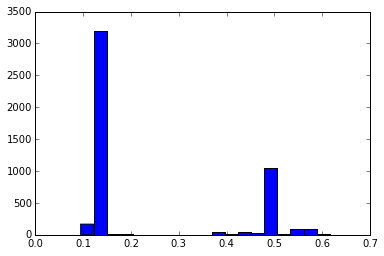

In [13]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [14]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [15]:
tp, fp, tn, fn = gen_model.score(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.8
Neg. class accuracy: 0.95
Precision            0.421
Recall               0.8
F1                   0.552
----------------------------------------
TP: 8 | FP: 11 | TN: 210 | FN: 2



In [16]:
L_dev.lf_stats(session, L_gold_dev, gen_model.weights.lf_accuracy())

/Users/bradenhancock/snorkel/snorkel/annotations.py:80: RuntimeWarning: invalid value encountered in divide
  ac = (tp+tn).astype(float) / (tp+tn+fp+fn)


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_distant_supervision,0,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.517299
LF_distant_supervision_last_names,1,0.004329,0.004329,0.004329,0,1,0,0,0.000000,0.515824
LF_husband_wife,2,0.077922,0.060606,0.008658,8,10,0,0,0.444444,0.519065
LF_husband_wife_left_window,3,0.064935,0.060606,0.008658,8,7,0,0,0.533333,0.521415
LF_same_last_name,4,0.012987,0.012987,0.004329,1,2,0,0,0.333333,0.516124
LF_no_spouse_in_sentence,5,0.623377,0.043290,0.008658,0,0,1,139,0.992857,0.706944
LF_and_married,6,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.516884
LF_familial_relationship,7,0.030303,0.021645,0.004329,0,0,0,7,1.000000,0.531623
LF_family_left_window,8,0.051948,0.034632,0.004329,0,0,1,11,0.916667,0.529861
LF_other_relationship,9,0.004329,0.004329,0.000000,0,0,0,1,1.000000,0.520964


### Discriminative Model

In [21]:
from snorkel.learning import SparseLogisticRegression
disc_model = SparseLogisticRegression()

In [22]:
from snorkel.learning.utils import MentionScorer
from snorkel.learning import RandomSearch, ListParameter, RangeParameter

# Searching over learning rate
rate_param = RangeParameter('lr', 1e-6, 1e-2, step=1, log_base=10)
l1_param  = RangeParameter('l1_penalty', 1e-6, 1e-2, step=1, log_base=10)
l2_param  = RangeParameter('l2_penalty', 1e-6, 1e-2, step=1, log_base=10)

searcher = RandomSearch(session, disc_model, F_unlabeled, train_marginals, [rate_param, l1_param, l2_param], n=20)

Initialized RandomSearch search of size 20. Search space size = 125.


In [ ]:
np.random.seed(1701)
searcher.fit(F_dev, L_gold_dev, n_epochs=50, rebalance=True, print_freq=25)

In [26]:
disc_model.train(F_unlabeled, train_marginals, n_epochs=20, lr=0.001)

[SparseLR] lr=0.001 l1=0.0 l2=0.0
[SparseLR] Building model
[SparseLR] Training model  #epochs=20  batch=100


InvalidArgumentError: segment ids are not increasing by 1
	 [[Node: embedding_lookup_sparse_5 = SegmentSum[T=DT_FLOAT, Tindices=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](embedding_lookup_sparse_5/mul, embedding_lookup_sparse_5/Cast)]]

Caused by op u'embedding_lookup_sparse_5', defined at:
  File "/Users/bradenhancock/anaconda/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/bradenhancock/anaconda/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 389, in start
    ioloop.IOLoop.instance().start()
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/tornado/ioloop.py", line 866, in start
    handler_func(fd_obj, events)
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 252, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 213, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 362, in execute_request
    user_expressions, allow_stdin)
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-505e45b541cc>", line 1, in <module>
    disc_model.train(F_unlabeled, train_marginals, n_epochs=20, lr=0.001)
  File "/Users/bradenhancock/snorkel/snorkel/learning/logistic_regression.py", line 88, in train
    self._build()
  File "/Users/bradenhancock/snorkel/snorkel/learning/logistic_regression.py", line 153, in _build
    params=w, sp_ids=sparse_ids, sp_weights=sparse_vals, combiner='sum'
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/embedding_ops.py", line 333, in embedding_lookup_sparse
    embeddings = math_ops.segment_sum(embeddings, segment_ids, name=name)
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2307, in segment_sum
    segment_ids=segment_ids, name=name)
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): segment ids are not increasing by 1
	 [[Node: embedding_lookup_sparse_5 = SegmentSum[T=DT_FLOAT, Tindices=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](embedding_lookup_sparse_5/mul, embedding_lookup_sparse_5/Cast)]]


In [ ]:
_, _, _, _ = disc_model.score(session, F_dev, L_gold_dev)